Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 16,812,610
Trainable params: 16,812,610
Non-trainable params: 0
_________________________________________________________________
Found 5216 images belonging to 2 classes.
Fo

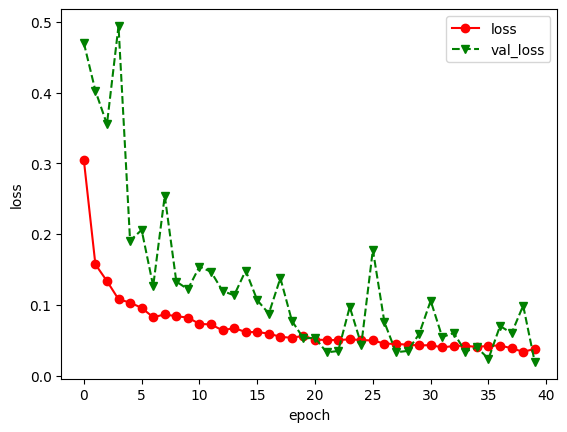

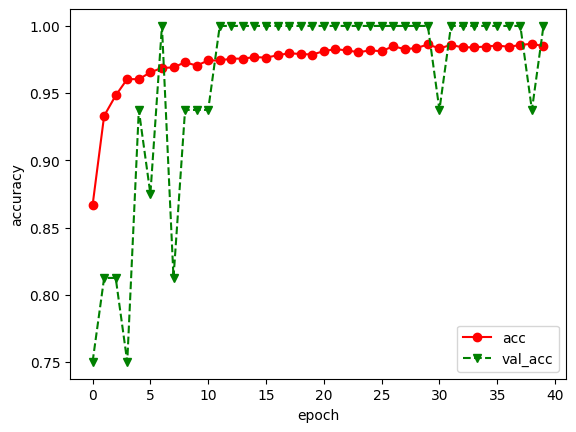

In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt


# 画像サイズとディレクトリの設定
img_width, img_height = 150, 150
train_data_dir = 'chest_xray/train'
val_data_dir = 'chest_xray/val'

# エポック数の設定
epoch = 40

# 分類クラス名の設定
classes = ['NORMAL','PNEUMONIA']
nb_classes = len(classes)

# VGG16モデルのロード
vgg_model = VGG16(
        include_top = False,
        weights = 'imagenet',
        input_shape = (img_height, img_width, 3))

# VGG16モデルの下に全結合層を追加
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

# VGG16モデルの上位15層のパラメータを凍結
# for layer in vgg_model.layers[:15]:
#     layer.trainable = False

model.summary()

# 損失関数は交差エントロピー、最適化手法はSGD
model.compile(
        loss = 'categorical_crossentropy',
        optimizer = SGD(0.001, 0.1),
        metrics = ['accuracy'])

# 学習データのデータ拡張を設定
train_datagen = ImageDataGenerator(
        rescale = 1.0 / 255,
        # shear_range = 0.2,
        zoom_range = 0.1,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=[0.9, 1.1],
        fill_mode="constant",
        horizontal_flip = True)

# 評価データのデータ拡張を設定
test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

# 学習データのジェネレータを生成
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_height, img_width),
        classes = classes,
        batch_size = 32,
        class_mode = 'categorical')

# 評価データのジェネレータを生成
val_generator = test_datagen.flow_from_directory(
        val_data_dir,
        target_size = (img_height, img_width),
        classes = classes,
        batch_size = 32,
        class_mode = 'categorical')

# コールバック関数（モデルの保存）の設定
mc_cb = ModelCheckpoint(
        filepath = 'pneumonia_3.h5',
        monitor = 'val_loss',
        verbose = 0,
        save_best_only = True)

# ジェネレータを用いたモデルの学習
history = model.fit(
    train_generator,
    epochs=epoch,
    validation_data = val_generator,
    callbacks = [mc_cb])

# 予測誤差のグラフ化
plt.plot(range(len(history.history['loss'])), history.history['loss'], marker='o', color = 'red', label='loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], marker='v', linestyle='--', color='green', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

# 予測精度のグラフ化
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], marker='o', color = 'red', label='acc')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], marker='v', linestyle='--', color = 'green', label='val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()
